In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to your data directory
import os
os.chdir('/content/drive/MyDrive/Saarland')

Mounted at /content/drive


In [ ]:
# Load data - only relevant columns
cols = ['League', 'Home', 'Away', 'Date', 'H_Score', 'A_Score']
df = pd.read_csv('various_football_league_scores.csv', usecols=cols)

print(f"Total matches: {len(df)}")
print(f"\nLeagues: {sorted(df['League'].unique())}")
df.head()

Total matches: 96337

Leagues: ['2-bundesliga', 'bundesliga', 'championship', 'eredivisie', 'fortuna-1-liga', 'jupiler-league', 'laliga', 'laliga2', 'league-one', 'league-two', 'liga-portugal', 'ligue-1', 'ligue-2', 'pko-bp-ekstraklasa', 'premier-league', 'serie-a', 'serie-b', 'super-lig']


,League,Home,Away,Date,H_Score,A_Score
0,championship,Swansea,Reading,30.05.2011,4.0,2.0
1,championship,Cardiff,Reading,17.05.2011,0.0,3.0
2,championship,Swansea,Nottingham,16.05.2011,3.0,1.0
3,championship,Reading,Cardiff,13.05.2011,0.0,0.0
4,championship,Nottingham,Swansea,12.05.2011,0.0,0.0


In [ ]:
# Parse dates and extract year
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
df['Year'] = df['Date'].dt.year

# Rename for consistency
df = df.rename(columns={'Home': 'HomeTeam', 'Away': 'AwayTeam', 'H_Score': 'FTHG', 'A_Score': 'FTAG'})

# Drop rows with missing scores or years
df = df.dropna(subset=['FTHG', 'FTAG', 'Year'])
df['FTHG'] = df['FTHG'].astype(int)
df['FTAG'] = df['FTAG'].astype(int)
df['Year'] = df['Year'].astype(int)

print(f"Valid matches after cleaning: {len(df)}")
print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"\nMatches per league:")
print(df['League'].value_counts().sort_index())

Valid matches after cleaning: 96305
Year range: 2002 - 2022

Matches per league:
League
2-bundesliga          3502
bundesliga            5838
championship          6680
eredivisie            5770
fortuna-1-liga        3685
jupiler-league        3754
laliga                7220
laliga2               5519
league-one            6434
league-two            6012
liga-portugal         3413
ligue-1               6753
ligue-2               4470
pko-bp-ekstraklasa    3337
premier-league        7600
serie-a               7150
serie-b               5284
super-lig             3884
Name: count, dtype: int64


## Calculate Per-Team Points Per Game (Peko's Method)

Following Getty et al. (2018), we calculate PPG for each team, then use random splits to compute R*.

In [ ]:
def get_team_games(df, team):
    """Get all games for a specific team"""
    home_games = df[df['HomeTeam'] == team].copy()
    home_games['is_home'] = True
    home_games['team_score'] = home_games['FTHG']
    home_games['opp_score'] = home_games['FTAG']
    home_games['opponent'] = home_games['AwayTeam']

    away_games = df[df['AwayTeam'] == team].copy()
    away_games['is_home'] = False
    away_games['team_score'] = away_games['FTAG']
    away_games['opp_score'] = away_games['FTHG']
    away_games['opponent'] = away_games['HomeTeam']

    team_games = pd.concat([home_games, away_games])
    team_games = team_games.sort_values('Date')

    # Calculate points (3 for win, 1 for draw, 0 for loss)
    team_games['points'] = 0
    team_games.loc[team_games['team_score'] > team_games['opp_score'], 'points'] = 3
    team_games.loc[team_games['team_score'] == team_games['opp_score'], 'points'] = 1

    return team_games

def calculate_r_peko_method(df_subset, n_folds=100):
    """
    Calculate R* using Peko's method:
    1. For each team, randomly split games K times
    2. Calculate PPG for each split
    3. Pool all (x,y) pairs across teams and splits
    4. Transform to S,T coordinates
    5. Calculate R = 1 - var(T)/var(S)
    """
    if len(df_subset) < 20:
        return np.nan

    teams = sorted(set(df_subset['HomeTeam']).union(set(df_subset['AwayTeam'])))

    # Collect all (x,y) pairs
    XY_pairs = []

    for team in teams:
        team_games = get_team_games(df_subset, team)
        n_games = len(team_games)

        # Skip teams with too few games
        if n_games < 4:
            continue

        # Perform K random splits for this team
        for k in range(n_folds):
            # Randomly assign games to fold A or B
            fold = np.random.randint(0, 2, n_games)

            games_a = team_games.iloc[fold == 0]
            games_b = team_games.iloc[fold == 1]

            # Calculate PPG (points per game)
            if len(games_a) > 0 and len(games_b) > 0:
                x = games_a['points'].sum() / len(games_a)
                y = games_b['points'].sum() / len(games_b)
                XY_pairs.append((x, y))

    if len(XY_pairs) < 3:
        return np.nan

    # Convert to arrays
    X = np.array([x for x, y in XY_pairs])
    Y = np.array([y for x, y in XY_pairs])

    # Transform to S, T coordinates
    S = (X + Y) / np.sqrt(2)
    T = (Y - X) / np.sqrt(2)

    # Calculate variances (using ddof=0)
    var_S = np.var(S, ddof=0)
    var_T = np.var(T, ddof=0)

    # Calculate R
    if var_S > 1e-12:
        R = 1 - var_T / var_S
    else:
        R = np.nan

    return R

## Calculate R for Each League by Year

In [ ]:
results = []

for league in sorted(df['League'].unique()):
    league_data = df[df['League'] == league]
    print(f"Processing {league}...")

    for year in sorted(league_data['Year'].unique()):
        year_data = league_data[league_data['Year'] == year]

        n_teams = len(set(year_data['HomeTeam']).union(set(year_data['AwayTeam'])))
        n_games = len(year_data)

        if n_games >= 20:
            r_val = calculate_r_peko_method(year_data, n_folds=100)

            results.append({
                'League': league,
                'Year': year,
                'N_Teams': n_teams,
                'N_Games': n_games,
                'R_Value': r_val
            })

results_df = pd.DataFrame(results)
results_df = results_df.round({'R_Value': 2})
print(f"\nTotal league-years analyzed: {len(results_df)}")
results_df.head(20)

Processing 2-bundesliga...
Processing bundesliga...
Processing championship...
Processing eredivisie...
Processing fortuna-1-liga...
Processing jupiler-league...
Processing laliga...
Processing laliga2...
Processing league-one...
Processing league-two...
Processing liga-portugal...
Processing ligue-1...
Processing ligue-2...
Processing pko-bp-ekstraklasa...
Processing premier-league...
Processing serie-a...
Processing serie-b...
Processing super-lig...

Total league-years analyzed: 274


,League,Year,N_Teams,N_Games,R_Value
0,2-bundesliga,2010,18,152,NaN
1,2-bundesliga,2011,23,327,0.75
2,2-bundesliga,2012,24,309,0.41
3,2-bundesliga,2013,23,308,0.54
4,2-bundesliga,2014,23,308,0.54
5,2-bundesliga,2015,23,308,0.36
6,2-bundesliga,2016,23,290,0.53
7,2-bundesliga,2017,23,317,0.56
8,2-bundesliga,2018,23,254,0.12
9,2-bundesliga,2019,24,167,-0.15


## Summary Statistics by League

In [ ]:
summary = results_df.groupby('League').agg({
    'R_Value': ['mean', 'std', 'min', 'max', 'count'],
    'Year': ['min', 'max']
}).round(3)

summary.columns = ['Mean_R', 'Std_R', 'Min_R', 'Max_R', 'N_Seasons', 'First_Year', 'Last_Year']
summary = summary.sort_values('Mean_R', ascending=False)
summary

,Mean_R,Std_R,Min_R,Max_R,N_Seasons,First_Year,Last_Year
League,,,,,,,
liga-portugal,0.762,0.063,0.65,0.84,13,2010,2022
premier-league,0.746,0.088,0.40,0.82,21,2002,2022
serie-a,0.740,0.071,0.62,0.86,20,2003,2022
laliga,0.697,0.086,0.50,0.80,20,2003,2022
eredivisie,0.678,0.129,0.38,0.86,19,2004,2022
super-lig,0.640,0.084,0.44,0.73,13,2010,2022
bundesliga,0.634,0.122,0.42,0.81,20,2003,2022
ligue-1,0.628,0.129,0.31,0.77,19,2004,2022
league-one,0.580,0.152,0.11,0.69,13,2010,2022


## Visualizations

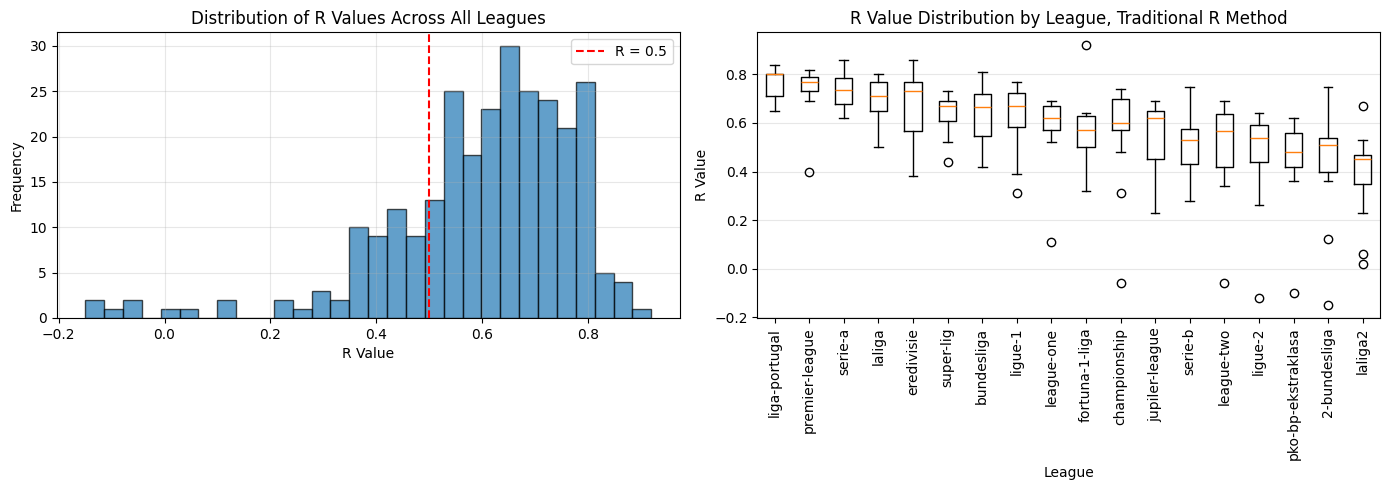

In [ ]:
# Overall R distribution across all leagues
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(results_df['R_Value'].dropna(), bins=30, alpha=0.7, edgecolor='black')
ax1.axvline(x=0.5, color='red', linestyle='--', label='R = 0.5')
ax1.set_xlabel('R Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of R Values Across All Leagues')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by league
league_order = summary.index.tolist()
data_for_box = [results_df[results_df['League'] == league]['R_Value'].dropna() for league in league_order]
ax2.boxplot(data_for_box, labels=league_order)
#ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('League')
ax2.set_ylabel('R Value')
ax2.set_title('R Value Distribution by League, Traditional R Method')
ax2.tick_params(axis='x', rotation=90)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

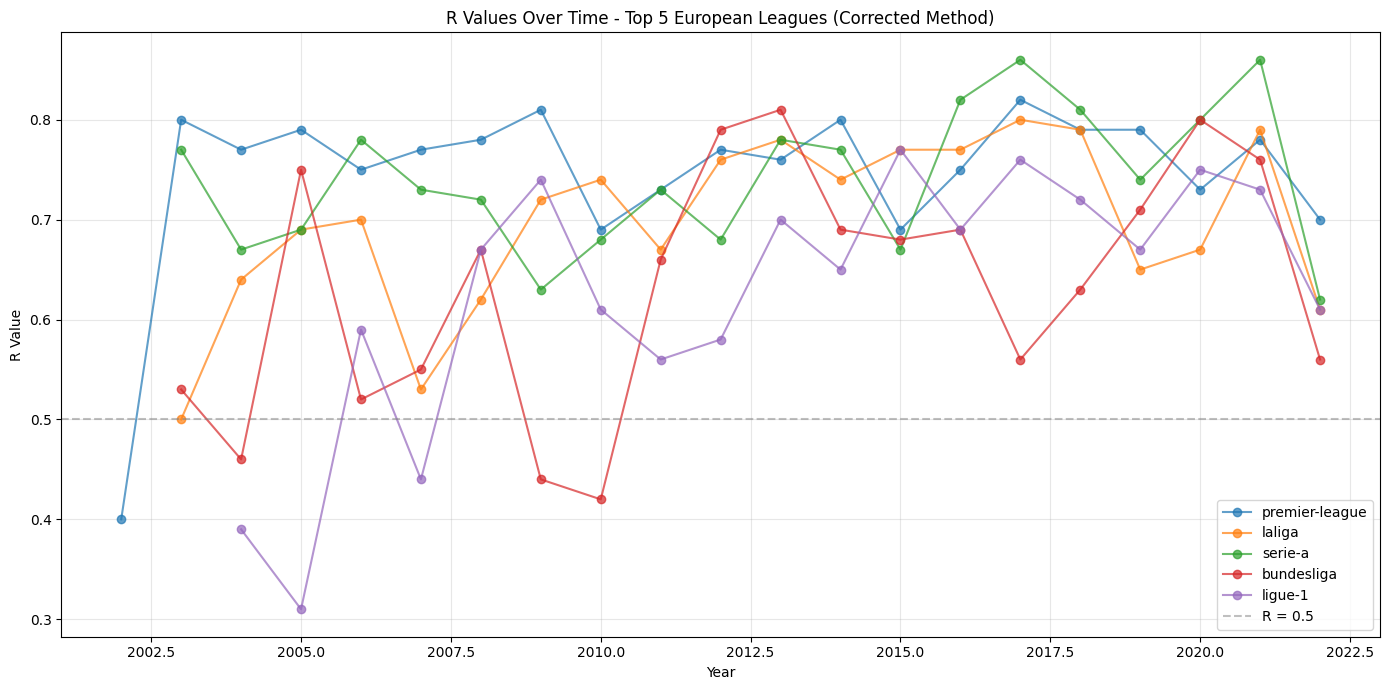

In [ ]:
# Time series for major leagues
major_leagues = ['premier-league', 'laliga', 'serie-a', 'bundesliga', 'ligue-1']

fig, ax = plt.subplots(figsize=(14, 7))

for league in major_leagues:
    league_data = results_df[results_df['League'] == league]
    ax.plot(league_data['Year'], league_data['R_Value'], 'o-', label=league, alpha=0.7)

ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='R = 0.5')
ax.set_xlabel('Year')
ax.set_ylabel('R Value')
ax.set_title('R Values Over Time - Top 5 European Leagues (Corrected Method)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

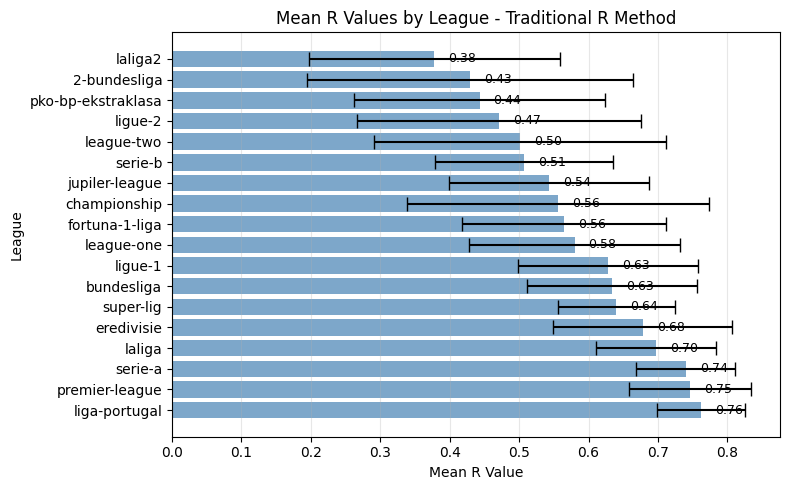

In [ ]:
# Bar chart of mean R by league
fig, ax = plt.subplots(figsize=(8, 5))

leagues = summary.index
means = summary['Mean_R']
stds = summary['Std_R']

# Single color for all bars
ax.barh(leagues, means, xerr=stds, color='steelblue', alpha=0.7, capsize=5)

# Add R values as text labels (rounded to 2 decimal places)
for i, (league, mean) in enumerate(zip(leagues, means)):
    ax.text(mean + 0.02, i, f'{mean:.2f}', va='center', fontsize=9)

ax.set_xlabel('Mean R Value')
ax.set_ylabel('League')
ax.set_title('Mean R Values by League - Traditional R Method')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

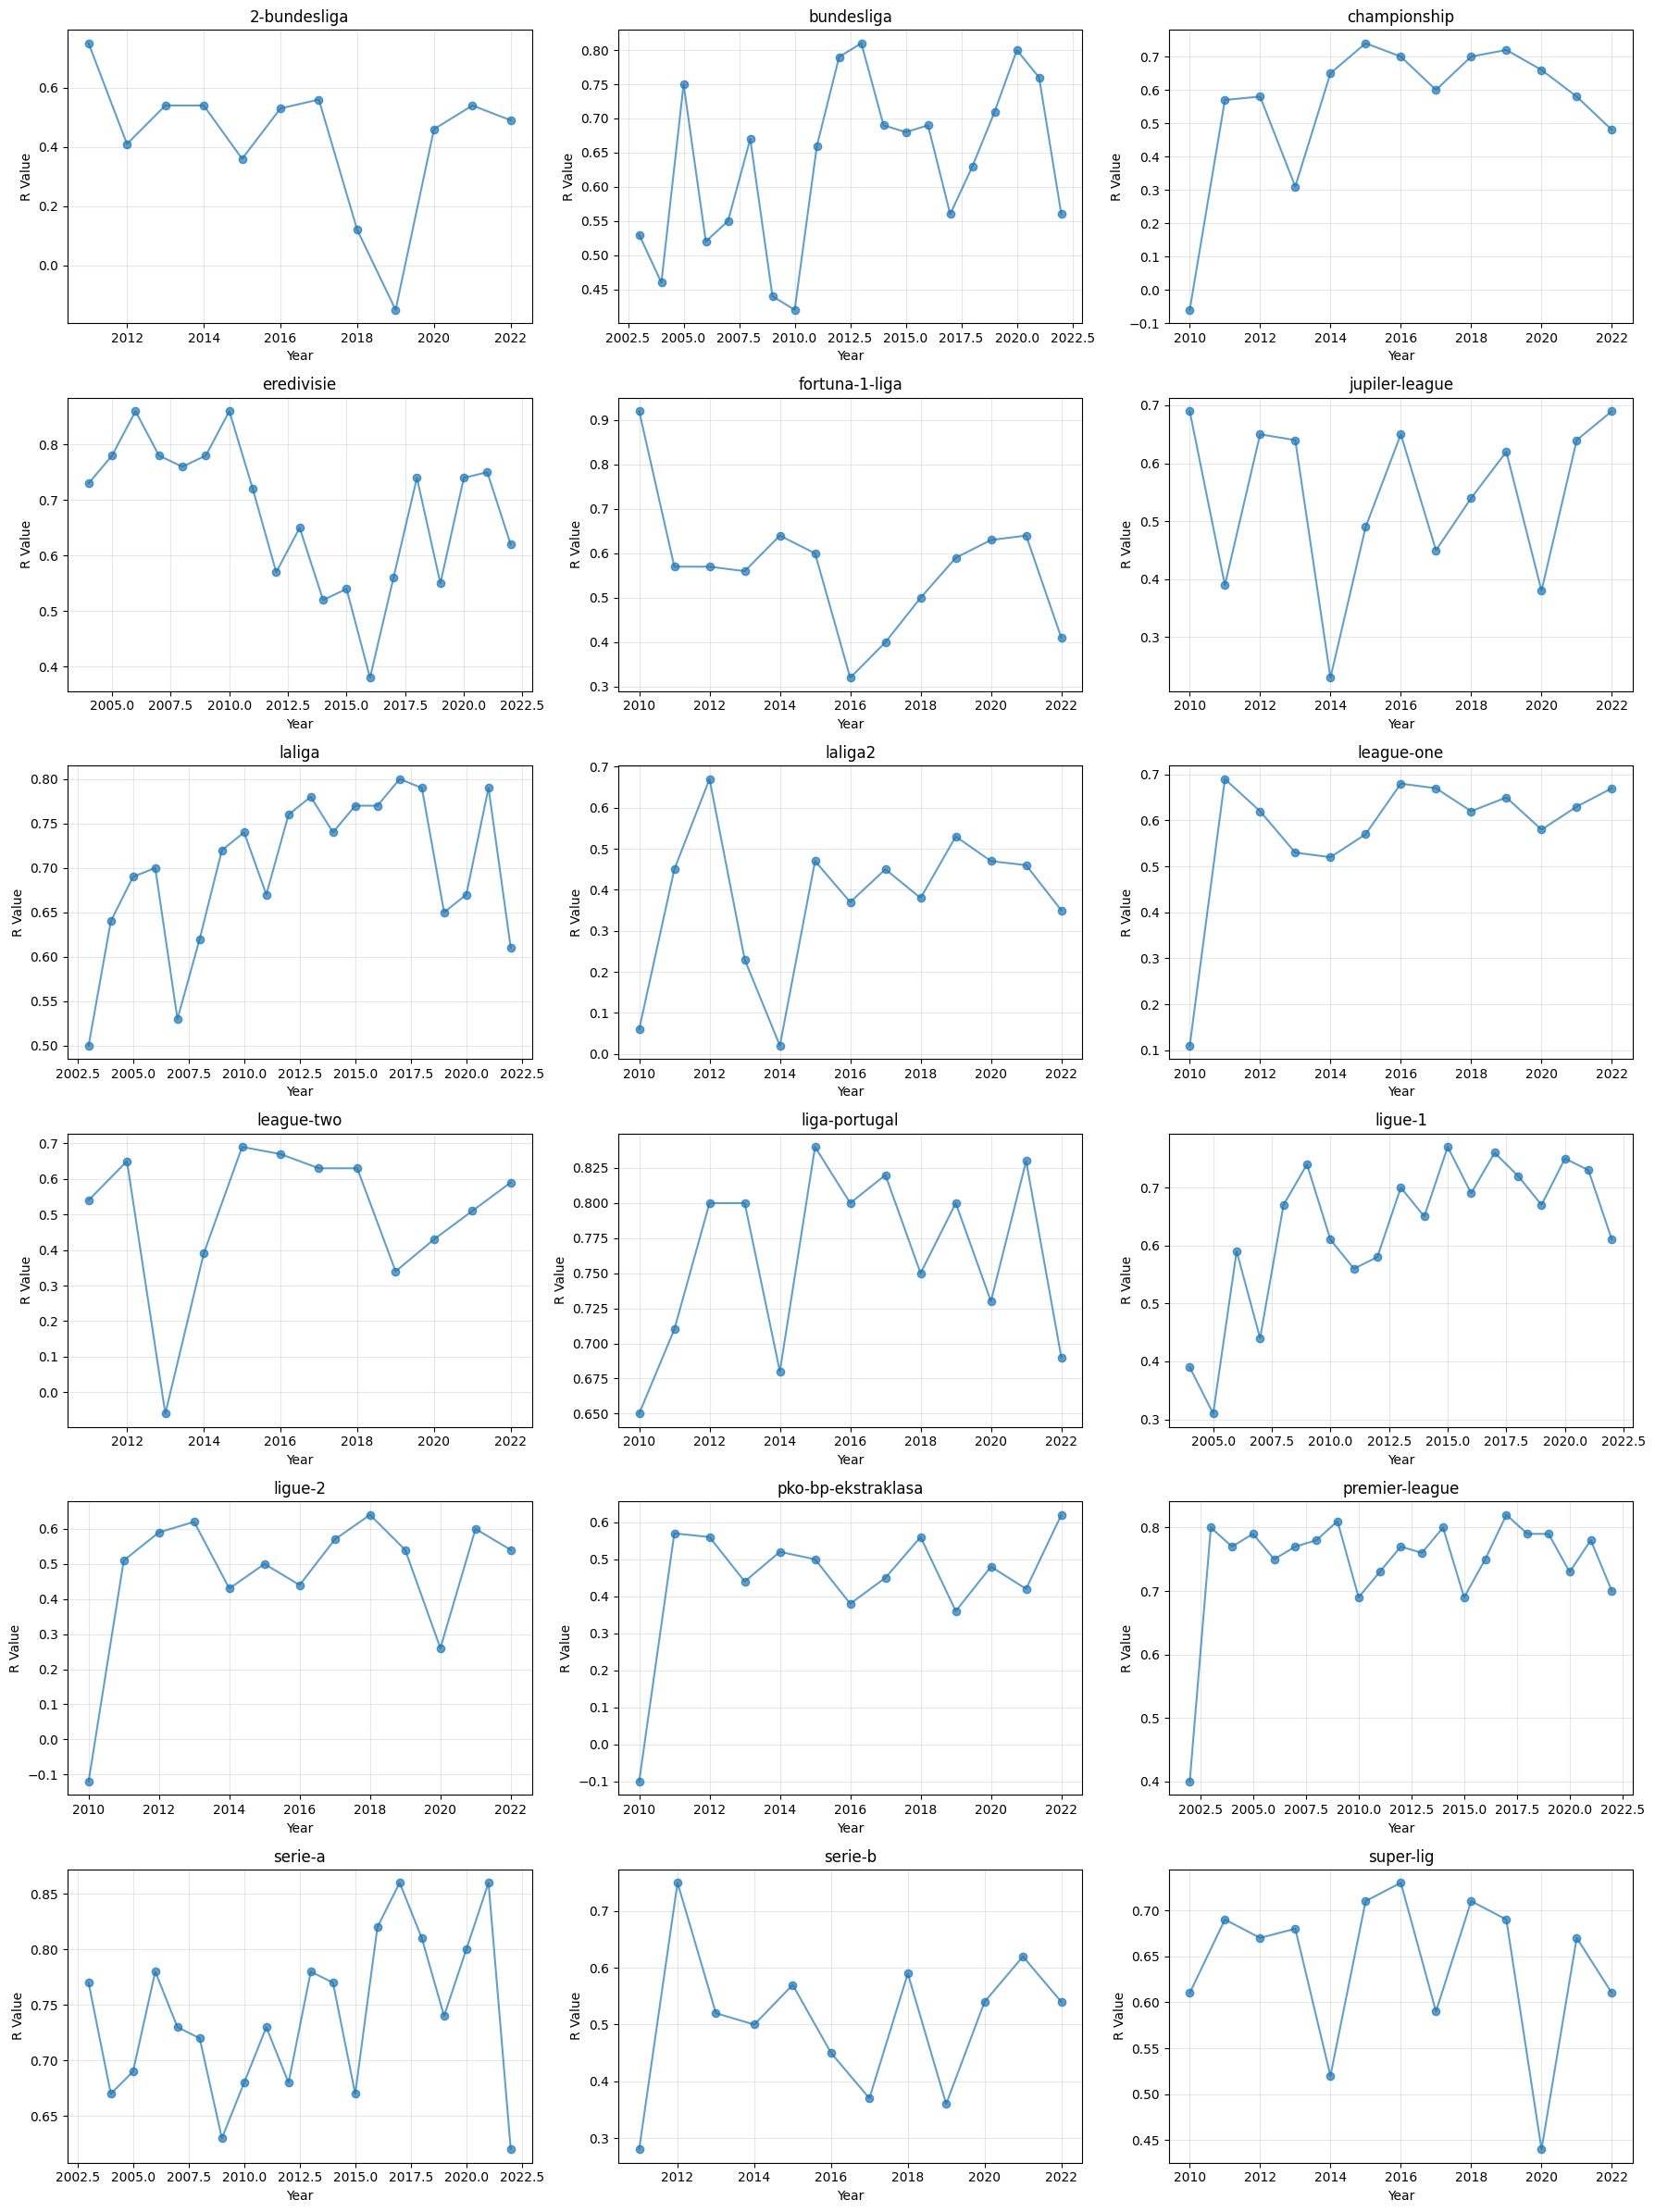

In [ ]:
# Create separate plots for each league
leagues = sorted(results_df['League'].unique())
n_leagues = len(leagues)
n_cols = 3
n_rows = (n_leagues + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for idx, league in enumerate(leagues):
    league_data = results_df[results_df['League'] == league]

    axes[idx].plot(league_data['Year'], league_data['R_Value'], 'o-', alpha=0.7)
    #axes[idx].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('R Value')
    axes[idx].set_title(f'{league}')
    axes[idx].grid(alpha=0.3)

# Hide extra subplots
for idx in range(n_leagues, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## Example P vs Q Scatter Plot

Show first vs second half PPG for Premier League 2019 season

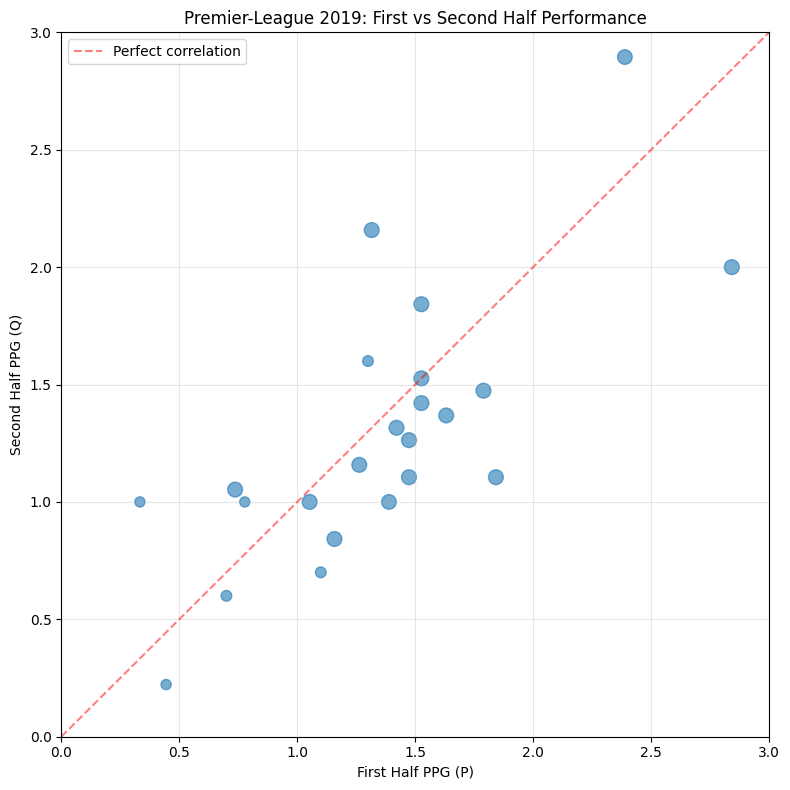


Correlation between first and second half: 0.733


In [ ]:
# Example: Premier League 2019
example_league = 'premier-league'
example_year = 2019

season_data = df[(df['League'] == example_league) & (df['Year'] == example_year)]
teams = sorted(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))

P_values = []
Q_values = []
game_counts = []

for team in teams:
    team_games = get_team_games(season_data, team)
    n_games = len(team_games)

    if n_games < 4:
        continue

    # Split into first and second half
    half = n_games // 2
    first_half = team_games.iloc[:half]
    second_half = team_games.iloc[half:]

    p = first_half['points'].sum() / len(first_half)
    q = second_half['points'].sum() / len(second_half)

    P_values.append(p)
    Q_values.append(q)
    game_counts.append(n_games)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
sizes = [g * 3 for g in game_counts]
ax.scatter(P_values, Q_values, s=sizes, alpha=0.6)
ax.plot([0, 3], [0, 3], 'r--', alpha=0.5, label='Perfect correlation')
ax.set_xlabel('First Half PPG (P)')
ax.set_ylabel('Second Half PPG (Q)')
ax.set_title(f'{example_league.title()} {example_year}: First vs Second Half Performance')
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between first and second half: {np.corrcoef(P_values, Q_values)[0,1]:.3f}")

## Export Results

In [ ]:
# Save detailed results
results_df.to_csv('european_leagues_r_values_corrected.csv', index=False)

# Save summary
summary.to_csv('european_leagues_summary_corrected.csv')

print("Results exported!")

Results exported!
